In [1]:
%%time
%reset -f

import pandas as pd
from rdkit.Chem import AllChem, Draw, Descriptors   
from rdkit import Chem, DataStructs
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Chem import rdMolDescriptors
from rdkit.DataStructs import ExplicitBitVect

curcumin_variants = (
    "COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC)cc(OC)cc1OC)=C2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1ccccc1cc3ccccc23)=C4)cc5",
    "COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)=[O+][B-](F)(F)O2)c3",
    "COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+][B-](F)(F)O2)ccc3O",
    "CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccccc1)=C2)cc3",
    "COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1)c2c34)=[O+][B-](F)(F)O5)cc6",
    "COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CN(C)c4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(N(C)C)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CCCCN(CCCC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(CCCC)CCCC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CN5/C(=C\C\C=C\C3=CC(/C=C/C/C=C/2N(C)c1ccccc1C2(C)C)=[O+][B-](F)(F)O3)C(C)(C)c4ccccc45",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc(SC)cc1)=C2)cc3",
    "CSc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(SC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc1ccccc1C/C=C/C3=CC(/C=C/Cc2ccccc2OC)=[O+][B-](F)(F)O3",
    "CCCCCC(CC)c5ccc(c4ccc(C/C=C/C3=CC(/C=C/Cc2ccc(c1ccc(C(CC)CCCCC)s1)s2)=[O+][B-](F)(F)O3)s4)s5"
)

molecule_names = ['2-ADMeO3', '3-MR83a', 'AD-10', 'AD-1013', 'AD-1022', 'AD-11', 'AD-14-Moore', 'AD-16-DMF', 'AD-18', 'AD-24', 'AD-25', 'AD-35', 'AD-4', 'AD-48', 'AD-5', 'AD-6', 'AD-7', 'AD-9', 'YD-30']
homo_lumo_gap = [3.077, 3.072, 3.259, 2.625, 2.938, 2.946, 2.811, 3.231, 2.735, 2.878, 2.686, 2.77, 3.001, 2.702, 2.97, 2.89, 2.859, 3.137, 2.525]

molecules = [Chem.MolFromSmiles(smiles) for smiles in curcumin_variants]
mws = [round(Descriptors.MolWt(mol),3) for mol in molecules]
logp = [Descriptors.MolLogP(mol) for mol in molecules]

# Create the initial DataFrame of Curcumin
data = {
    'Molecule': molecule_names,
    'Molecular Weight': mws,
    'LogP': logp,
    'Homo-Lumo Gap (eV)': homo_lumo_gap,
    'Smiles': curcumin_variants
}
curcumin_df = pd.DataFrame(data)

def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors gracefully."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception:
        return None
    return None

# apply morgan fingerprint to the curcumin_df dataframe
curcumin_df['Morgan_Fingerprints'] = curcumin_df['Smiles'].apply(generate_morgan_fingerprint_safe)
curcumin_df = curcumin_df[curcumin_df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
morgan_df = pd.DataFrame(curcumin_df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])

curcumin_df_mf = pd.concat([curcumin_df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)

# Convert any fingerprint to a bit vector
def convert_to_bit_vector(fp, nBits=2048):
    bit_vector = ExplicitBitVect(nBits)
    for bit in fp.GetNonzeroElements().keys():
        bit_vector.SetBit(bit % nBits)
    return bit_vector

# Atom pair Fingerprint bit vector conversion
def generate_atom_pair_fingerprint(mol, nBits=2048):
    fp = rdMolDescriptors.GetAtomPairFingerprint(mol)
    return convert_to_bit_vector(fp, nBits)

# Function to generate fingerprints
def generate_fingerprint(mol, fp_type, radius=2, n_bits=2048):
    if fp_type == 'morgan':
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits, useChirality=True)
    elif fp_type == 'fcfp':
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=n_bits, useChirality=True)
    elif fp_type == 'atom_pair':
        return generate_atom_pair_fingerprint(mol, nBits=n_bits)

# Similarity functions
def calculate_similarity(fp1, fp2, metric):
    if metric == 'tanimoto':
        return DataStructs.TanimotoSimilarity(fp1, fp2)
    elif metric == 'dice':
        return DataStructs.DiceSimilarity(fp1, fp2)
    elif metric == 'cosine':
        return DataStructs.CosineSimilarity(fp1, fp2)
    elif metric == 'kulczynski':
        return DataStructs.KulczynskiSimilarity(fp1, fp2)

curcumin_similarity_variants = {
    "seg01" : "Cc2ccc(/C=C/C(=O)CC(=O)/C=C/c1ccc(C)cc1)cc2",
    "seg02" : "C/C=C/C(=O)CC(=O)/C=C/c1ccc(C)cc1",
    "seg03" : "C/C=C/C(=O)CC(=O)/C=C/C",
    "seg04" : "Cc1ccc(/C=C/C=O)cc1",
    "seg05" : "C/C=C/C=O",
    "seg06" : "C/C=C/C1=CC(/C=C/C)=[O+][B-](F)(F)O1",
}

# Harvard OPV dataset import
data = pd.read_csv('https://raw.githubusercontent.com/AjStephan/havard-smile-opv/main/Non-fullerene%20small-molecules%20acceptors.csv')
opv_df = data.drop(columns=[
    'index', 'inchikey', 'LUMO_calib_stds', 'HOMO_calib_stds',
    'molW', 'PCE_calc', 'Voc_calc', 'Jsc_calc',
    'FF_calc', 'EQE_calc', 'PCE_calib', 'Voc_calib', 'Jsc_calib', 'FF_calib',
    'EQE_calib', 'PCE_cdiff', 'PCE_calib_plus'], axis=1)

opv_df['mol'] = opv_df['smiles'].apply(Chem.MolFromSmiles)

opv_df_sorted = opv_df.sort_values(by='LUMO_calc')
opv_df_filtered = opv_df_sorted[opv_df_sorted['LUMO_calc'] <= -3.5]
opv_df_filtered.reset_index(drop=True, inplace=True)

# Dictionary to hold the dataframes
similarity_dfs = {}

# Fingerprints and similarity methods
fingerprints = ['morgan', 'atom_pair']
similarities = ['tanimoto', 'cosine', 'kulczynski', 'dice']

# Loop over curcumin segments, fingerprints, and similarities
for key, smiles in curcumin_similarity_variants.items():
    specific_mol = Chem.MolFromSmiles(smiles)
    
    for fp_type in fingerprints:
        specific_fp = generate_fingerprint(specific_mol, fp_type)
        
        for sim_metric in similarities:
            opv_df_sim_segment = opv_df_filtered.copy()
            opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'] = opv_df_sim_segment['mol'].apply(lambda x: calculate_similarity(generate_fingerprint(x, fp_type), specific_fp, sim_metric))
            
            # Filter top 48% similar molecules
            quantile_value = opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'].quantile(0.20)
            opv_df_sim_segment = opv_df_sim_segment[opv_df_sim_segment[f'similarity_{key}_{fp_type}_{sim_metric}'] >= quantile_value]
            
            # Keep only the relevant columns (initial columns + similarity)
            opv_df_sim_segment = opv_df_sim_segment[['smiles', 'mol', 'GAP_calc', f'similarity_{key}_{fp_type}_{sim_metric}']]
            
            # Store the filtered dataframe in the dictionary
            similarity_dfs[f'{key}_{fp_type}_{sim_metric}'] = opv_df_sim_segment

            print(f"Generated dataframe for segment {key}, fingerprint {fp_type}, similarity {sim_metric}: shape {opv_df_sim_segment.shape}")

Generated dataframe for segment seg01, fingerprint morgan, similarity tanimoto: shape (10214, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity cosine: shape (10215, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity kulczynski: shape (10211, 4)
Generated dataframe for segment seg01, fingerprint morgan, similarity dice: shape (10214, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity tanimoto: shape (10201, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity cosine: shape (10206, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity kulczynski: shape (10212, 4)
Generated dataframe for segment seg01, fingerprint atom_pair, similarity dice: shape (10201, 4)
Generated dataframe for segment seg02, fingerprint morgan, similarity tanimoto: shape (10213, 4)
Generated dataframe for segment seg02, fingerprint morgan, similarity cosine: shape (10203, 4)
Generated dataframe for segm

In [2]:
opv_df_filtered.columns

Index(['smiles', 'HOMO_calc', 'LUMO_calc', 'LUMO_calib', 'HOMO_calib',
       'GAP_calib', 'GAP_calc', 'mol'],
      dtype='object')

In [3]:
similarity_dfs["seg01_atom_pair_cosine"].columns

Index(['smiles', 'mol', 'GAP_calc', 'similarity_seg01_atom_pair_cosine'], dtype='object')

In [4]:
%%time
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors

# Function to generate Morgan fingerprints safely
def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors gracefully."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception as e:
        print(f"Error generating Morgan fingerprint for SMILES {smiles}: {e}")
        return None
    return None

# Dictionary to store processed dataframes
processed_similarity_dfs = {}

# Process each dataframe
for combination, df in similarity_dfs.items():
    print(f"Processing {combination}...")
    df = df.copy()
    
    # Generate Morgan fingerprints
    df['Morgan_Fingerprints'] = df['smiles'].apply(generate_morgan_fingerprint_safe)
    df = df[df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
    
    # Convert Morgan fingerprints to a DataFrame and concatenate with the original
    morgan_df = pd.DataFrame(df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])

    df_combined = pd.concat([df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)
    
    # Store the combined DataFrame
    processed_similarity_dfs[combination] = df_combined
    print(f"Finished processing {combination} - shape {df_combined.shape}")

# Unpacking the dictionary to individual DataFrames
for combination, df in processed_similarity_dfs.items():
    globals()[f'similarity_dfs_{combination}'] = df

Processing seg01_morgan_tanimoto...
Finished processing seg01_morgan_tanimoto - shape (10214, 2052)
Processing seg01_morgan_cosine...
Finished processing seg01_morgan_cosine - shape (10215, 2052)
Processing seg01_morgan_kulczynski...
Finished processing seg01_morgan_kulczynski - shape (10211, 2052)
Processing seg01_morgan_dice...
Finished processing seg01_morgan_dice - shape (10214, 2052)
Processing seg01_atom_pair_tanimoto...
Finished processing seg01_atom_pair_tanimoto - shape (10201, 2052)
Processing seg01_atom_pair_cosine...
Finished processing seg01_atom_pair_cosine - shape (10206, 2052)
Processing seg01_atom_pair_kulczynski...
Finished processing seg01_atom_pair_kulczynski - shape (10212, 2052)
Processing seg01_atom_pair_dice...
Finished processing seg01_atom_pair_dice - shape (10201, 2052)
Processing seg02_morgan_tanimoto...
Finished processing seg02_morgan_tanimoto - shape (10213, 2052)
Processing seg02_morgan_cosine...
Finished processing seg02_morgan_cosine - shape (10203, 20

In [5]:
processed_similarity_dfs["seg01_atom_pair_cosine"].columns

Index(['smiles', 'mol', 'GAP_calc', 'similarity_seg01_atom_pair_cosine',
       'morgan_0', 'morgan_1', 'morgan_2', 'morgan_3', 'morgan_4', 'morgan_5',
       ...
       'morgan_2038', 'morgan_2039', 'morgan_2040', 'morgan_2041',
       'morgan_2042', 'morgan_2043', 'morgan_2044', 'morgan_2045',
       'morgan_2046', 'morgan_2047'],
      dtype='object', length=2052)

In [6]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm as lgb
import math

# Mappings for segments, fingerprint types, and similarity methods
segment_map = {
    'seg01': 'Segment 01',
    'seg02': 'Segment 02',
    'seg03': 'Segment 03',
    'seg04': 'Segment 04',
    'seg05': 'Segment 05',
    "seg06" : "Segment 06",
}

fingerprint_map = {
    'morgan': 'Morgan Fingerprint',
    'atom_pair': 'Atom Pair Fingerprint'
}

similarity_map = {
    'tanimoto': 'Tanimoto Similarity',
    'cosine': 'Cosine Similarity',
    'kulczynski': 'Kulczynski Similarity',
    'dice': 'Dice Similarity'
}

# Initialize a list to store results
results = []

# Process each dataframe from the global namespace
for combination, df in processed_similarity_dfs.items():
    print(f"Processing {combination}...")
    
    # Extract features (X) and target (y)
    X = df.iloc[:, 4:]  # Assuming the first 4 columns are non-feature columns
    y = df['GAP_calc']  # Target variable
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
    
    # Initialize and train the LightGBM model
    tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
    model = lgb.LGBMRegressor(**tuned_params)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate R^2 scores and RMSE
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = math.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))
    
    # Extracting segment, fingerprint type, and similarity method from the combination name
    parts = combination.split('_')  # Split the combination string into parts
    
    # Handle the case where the fingerprint type is 'atom_pair'
    if '_'.join(parts[1:3]) == 'atom_pair':
        segment_key = parts[0]  # Assuming the segment is the first part
        fingerprint_type_key = '_'.join(parts[1:3])  # Join parts to get 'atom_pair'
        similarity_method_key = parts[3]  # Similarity method is the fourth part
    else:
        segment_key = parts[0]  # Assuming the segment is the first part
        fingerprint_type_key = parts[1]  # Fingerprint type is the second part
        similarity_method_key = parts[2]  # Similarity method is the third part
    
    # Map the keys to human-readable names using the mappings
    segment_name = segment_map.get(segment_key, segment_key)
    fingerprint_name = fingerprint_map.get(fingerprint_type_key, fingerprint_type_key)
    similarity_name = similarity_map.get(similarity_method_key, similarity_method_key)
    
    # Store results in the list
    results.append({
        'Segment': segment_name,
        'Fingerprint Type': fingerprint_name,
        'Similarity Method': similarity_name,
        'Train R2 Score': train_r2,
        'Test R2 Score': test_r2,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse
    })
    
    print(f"Done processing {combination} with Test R^2 score: {test_r2} and Test RMSE: {test_rmse}")

# Convert results to a DataFrame for further analysis
final_results = pd.DataFrame(results)

# Save the results to a CSV file for further use
final_results.to_csv(path_or_buf=r"C:\Users\Chamod Peiris\Documents\Curcumin_Scripts\LUMO_Filtered_Segmented_Analysis.csv")

# Display the first few rows of the results
final_results.head()

Processing seg01_morgan_tanimoto...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2152
[LightGBM] [Info] Number of data points in the train set: 7660, number of used features: 1076
[LightGBM] [Info] Start training from score 2.700561
Done processing seg01_morgan_tanimoto with Test R^2 score: 0.947292137480311 and Test RMSE: 0.13062138097482998
Processing seg01_morgan_cosine...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2156
[LightGBM] [Info] Number of data points in the train set: 7661, number of used features: 1078
[LightGBM] [Info] Start training from score 2.696034
Done

,Segment,Fingerprint Type,Similarity Method,Train R2 Score,Test R2 Score,Train RMSE,Test RMSE
0,Segment 01,Morgan Fingerprint,Tanimoto Similarity,0.998247,0.947292,0.024285,0.130621
1,Segment 01,Morgan Fingerprint,Cosine Similarity,0.998102,0.940226,0.025462,0.134562
2,Segment 01,Morgan Fingerprint,Kulczynski Similarity,0.998565,0.950829,0.021104,0.122899
3,Segment 01,Morgan Fingerprint,Dice Similarity,0.998247,0.947292,0.024285,0.130621
4,Segment 01,Atom Pair Fingerprint,Tanimoto Similarity,0.998219,0.946296,0.023241,0.127883


In [7]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# Load the results from the CSV file
final_results = pd.read_csv(r"C:\Users\Chamod Peiris\Documents\Curcumin_Scripts\LUMO_Filtered_Segmented_Analysis.csv")

# Calculate the absolute variance between Train and Test R² scores
final_results['Variance'] = abs(final_results['Train R2 Score'] - final_results['Test R2 Score'])

# Create six plots, one for each segment
for segment in final_results['Segment'].unique():
    # Filter data for the current segment
    segment_data = final_results[final_results['Segment'] == segment]
    
    # Identify the best model (highest Test R² score)
    best_model = segment_data.loc[segment_data['Test R2 Score'].idxmax()]
    
    # Create a grouped bar plot for Train and Test R² scores
    fig = go.Figure()
    
    # Add bars for Train R² scores
    fig.add_trace(go.Bar(
        x=segment_data['Fingerprint Type'] + ' - ' + segment_data['Similarity Method'],
        y=segment_data['Train R2 Score'],
        name='Train R² Score',
        marker_color='blue',
        text=segment_data['Train R2 Score'].round(4),
        textposition='auto'
    ))
    
    # Add bars for Test R² scores
    fig.add_trace(go.Bar(
        x=segment_data['Fingerprint Type'] + ' - ' + segment_data['Similarity Method'],
        y=segment_data['Test R2 Score'],
        name='Test R² Score',
        marker_color='orange',
        text=segment_data['Test R2 Score'].round(4),
        textposition='auto'
    ))
    
    # Add a line for the absolute variance (secondary y-axis)
    fig.add_trace(go.Scatter(
        x=segment_data['Fingerprint Type'] + ' - ' + segment_data['Similarity Method'],
        y=segment_data['Variance'],
        mode='lines+markers',
        name='Absolute Variance',
        yaxis='y2',
        line=dict(color='red', dash='dash')
    ))
    
    # Update layout to include secondary y-axis
    fig.update_layout(
        title=f'R² Scores and Variance for {segment}',
        xaxis_title='Fingerprint Type - Similarity Method',
        yaxis_title='R² Score',
        yaxis2=dict(
            title='Absolute Variance',
            overlaying='y',
            side='right',
            showgrid=False,
            zeroline=False
        ),
        barmode='group',
        legend=dict(x=0.85, y=1.0),
        width=1000,
        height=600
    )
    
    # Add annotation for the best model
    fig.add_annotation(
        x=best_model['Fingerprint Type'] + ' - ' + best_model['Similarity Method'],
        y=best_model['Test R2 Score'],
        text=f"Best Model:<br>Test R²={best_model['Test R2 Score']:.4f}<br>{best_model['Fingerprint Type']} - {best_model['Similarity Method']}",
        showarrow=True,
        arrowhead=3,
        ax=0,
        ay=-50,
        font=dict(color="black", size=12),
        bgcolor="silver"
    )

    # legend orientation
    fig.update_layout(
    legend=dict(
        orientation='h',  # Horizontal orientation
        yanchor='bottom',
        y=1.01,  # Position above the plot
        xanchor='center',
        x=0.5  # Center horizontally
    )
)
    
    # Show the plot
    fig.show()

In [8]:
import pandas as pd
import plotly.graph_objects as go

# Load the results from the CSV file
final_results = pd.read_csv(r"C:\Users\Chamod Peiris\Documents\Curcumin_Scripts\LUMO_Filtered_Segmented_Analysis.csv")

# Calculate the absolute variance between Train and Test R² scores
final_results['Variance'] = abs(final_results['Train R2 Score'] - final_results['Test R2 Score'])

# Initialize an empty list to store the best models from all segments
best_models_list = []

# Process each segment to find the best model
for segment in final_results['Segment'].unique():
    # Filter data for the current segment
    segment_data = final_results[final_results['Segment'] == segment]
    
    # Identify the best model (highest Test R² score)
    best_model = segment_data.loc[segment_data['Test R2 Score'].idxmax()]
    
    # Convert the Series to a DataFrame and append it to the list
    best_models_list.append(pd.DataFrame([best_model]))

# Concatenate the list of best models into a DataFrame
best_models_all_segments = pd.concat(best_models_list, ignore_index=True)

# Create a grouped bar plot for Train and Test R² scores of the best models
fig = go.Figure()

# Add bars for Train R² scores
fig.add_trace(go.Bar(
    x=best_models_all_segments['Segment'] + ' - ' + best_models_all_segments['Fingerprint Type'] + ' - ' + best_models_all_segments['Similarity Method'],
    y=best_models_all_segments['Train R2 Score'],
    name='Train R² Score',
    marker_color='blue',
    text=best_models_all_segments['Train R2 Score'].round(4),
    textposition='auto'
))

# Add bars for Test R² scores
fig.add_trace(go.Bar(
    x=best_models_all_segments['Segment'] + ' - ' + best_models_all_segments['Fingerprint Type'] + ' - ' + best_models_all_segments['Similarity Method'],
    y=best_models_all_segments['Test R2 Score'],
    name='Test R² Score',
    marker_color='orange',
    text=best_models_all_segments['Test R2 Score'].round(4),
    textposition='auto'
))

# Add a line for the absolute variance (secondary y-axis)
fig.add_trace(go.Scatter(
    x=best_models_all_segments['Segment'] + ' - ' + best_models_all_segments['Fingerprint Type'] + ' - ' + best_models_all_segments['Similarity Method'],
    y=best_models_all_segments['Variance'],
    mode='lines+markers',
    name='Absolute Variance',
    yaxis='y2',
    line=dict(color='red', dash='dash')
))

# Update layout to include secondary y-axis
fig.update_layout(
    title='Best Models Across All Segments',
    xaxis_title='Model',
    yaxis_title='R² Score',
    yaxis2=dict(
        title='Absolute Variance',
        overlaying='y',
        side='right',
        showgrid=False,
        zeroline=False
    ),
    barmode='group',
    legend=dict(x=0.85, y=1.0),
    width=1000,
    height=600
)

# legend orientation
fig.update_layout(
    legend=dict(
        orientation='h',  # Horizontal orientation
        yanchor='bottom',
        y=1.01,  # Position above the plot
        xanchor='center',
        x=0.5  # Center horizontally
    )
)

# Show the plot
fig.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2106
[LightGBM] [Info] Number of data points in the train set: 7654, number of used features: 1053
[LightGBM] [Info] Start training from score 2.665950


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



___________________________________________________________________
Model similarity_dfs_seg01_atom_pair_cosine
MAE Value: 0.08618 & RMSE Value: 0.17512
Prediction --> model MAE: 0.18658 & RMSE: 0.06027
Prediction --> model R2 Score: -0.5693
___________________________________________________________________


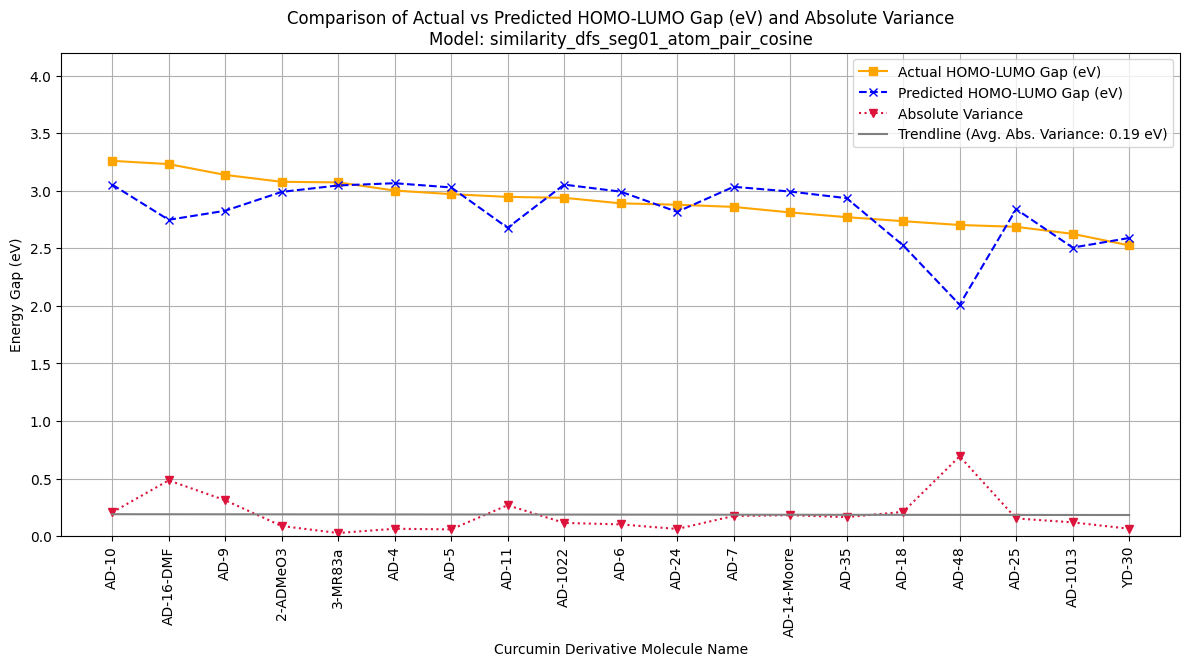

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 7649, number of used features: 1045
[LightGBM] [Info] Start training from score 2.678956


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



___________________________________________________________________
Model similarity_dfs_seg02_atom_pair_cosine
MAE Value: 0.08232 & RMSE Value: 0.11759
Prediction --> model MAE: 0.15145 & RMSE: 0.02929
Prediction --> model R2 Score: 0.2374
___________________________________________________________________


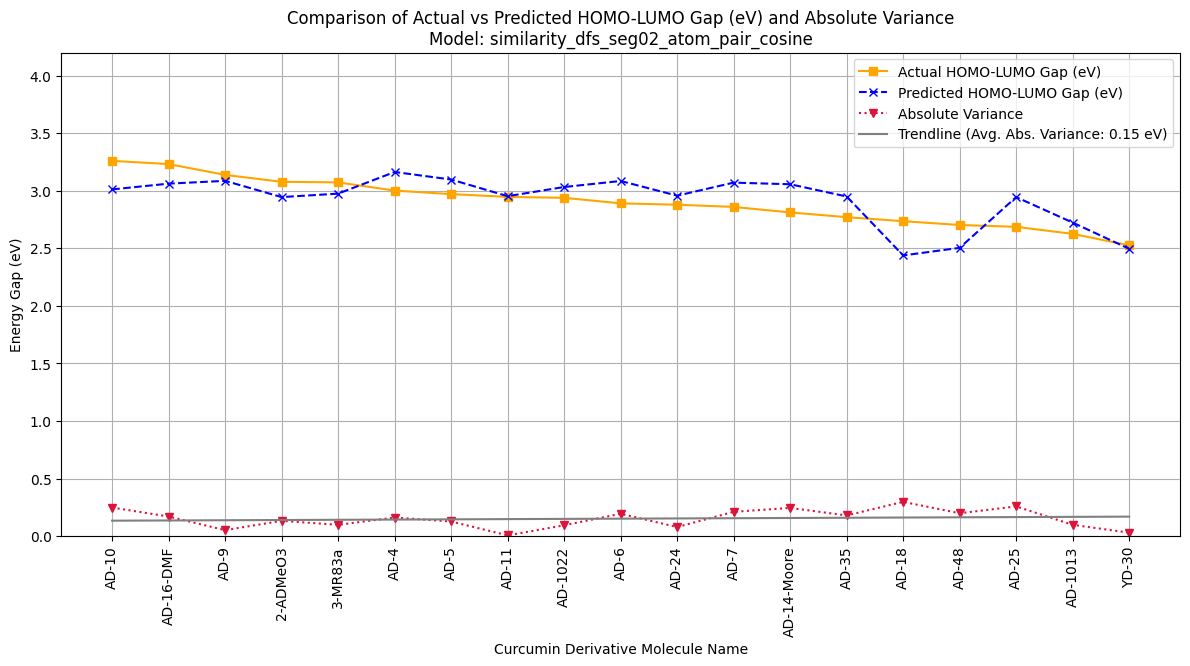

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2112
[LightGBM] [Info] Number of data points in the train set: 7632, number of used features: 1056
[LightGBM] [Info] Start training from score 2.694504


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



___________________________________________________________________
Model similarity_dfs_seg03_atom_pair_kulczynski
MAE Value: 0.08727 & RMSE Value: 0.12501
Prediction --> model MAE: 0.17989 & RMSE: 0.05580
Prediction --> model R2 Score: -0.4530
___________________________________________________________________


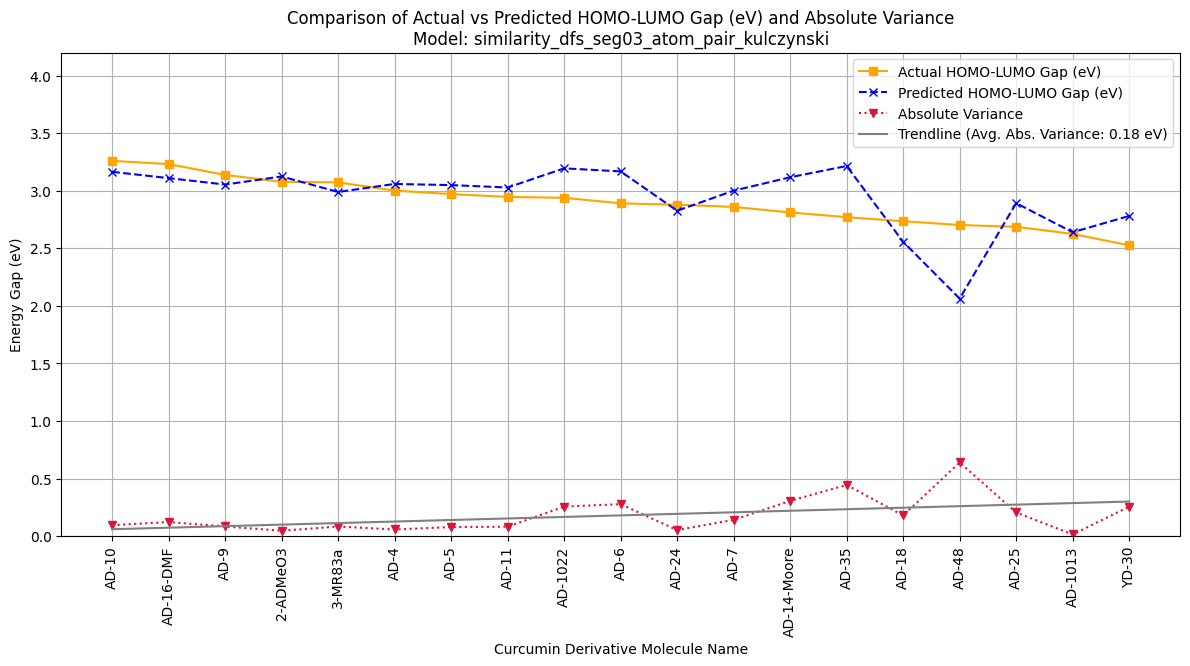

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2102
[LightGBM] [Info] Number of data points in the train set: 7712, number of used features: 1051
[LightGBM] [Info] Start training from score 2.700722


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



___________________________________________________________________
Model similarity_dfs_seg04_atom_pair_kulczynski
MAE Value: 0.08625 & RMSE Value: 0.13299
Prediction --> model MAE: 0.10939 & RMSE: 0.01804
Prediction --> model R2 Score: 0.5304
___________________________________________________________________


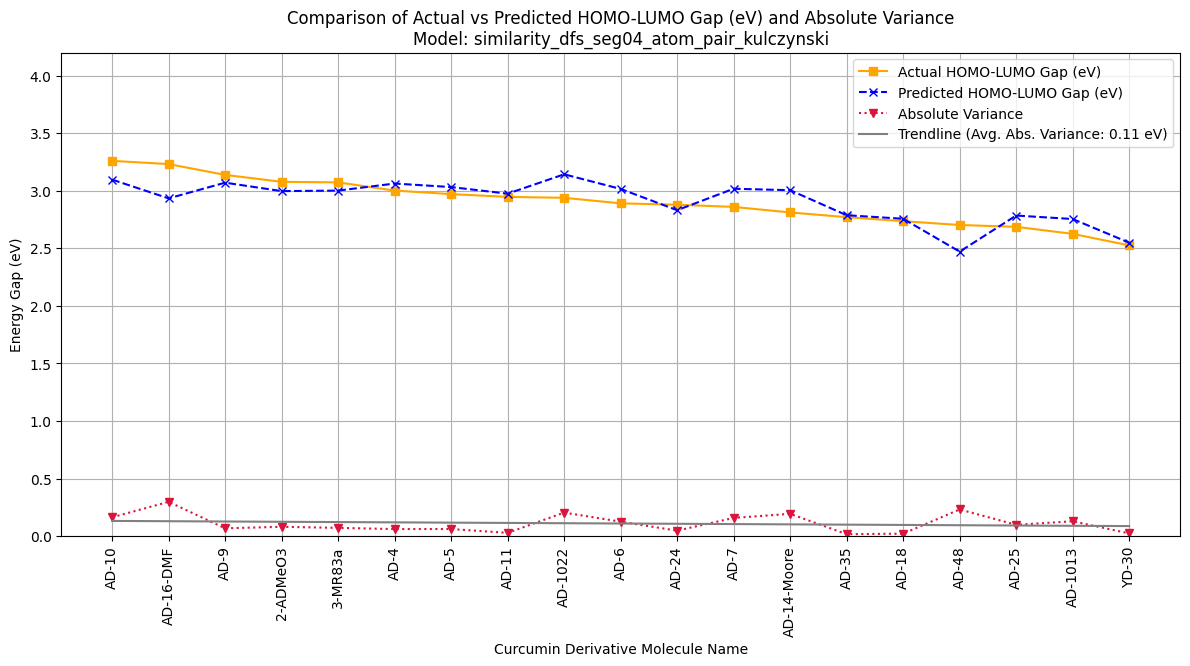

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2092
[LightGBM] [Info] Number of data points in the train set: 7684, number of used features: 1046
[LightGBM] [Info] Start training from score 2.702983


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



___________________________________________________________________
Model similarity_dfs_seg05_atom_pair_kulczynski
MAE Value: 0.08974 & RMSE Value: 0.23035
Prediction --> model MAE: 0.23233 & RMSE: 0.09641
Prediction --> model R2 Score: -1.5102
___________________________________________________________________


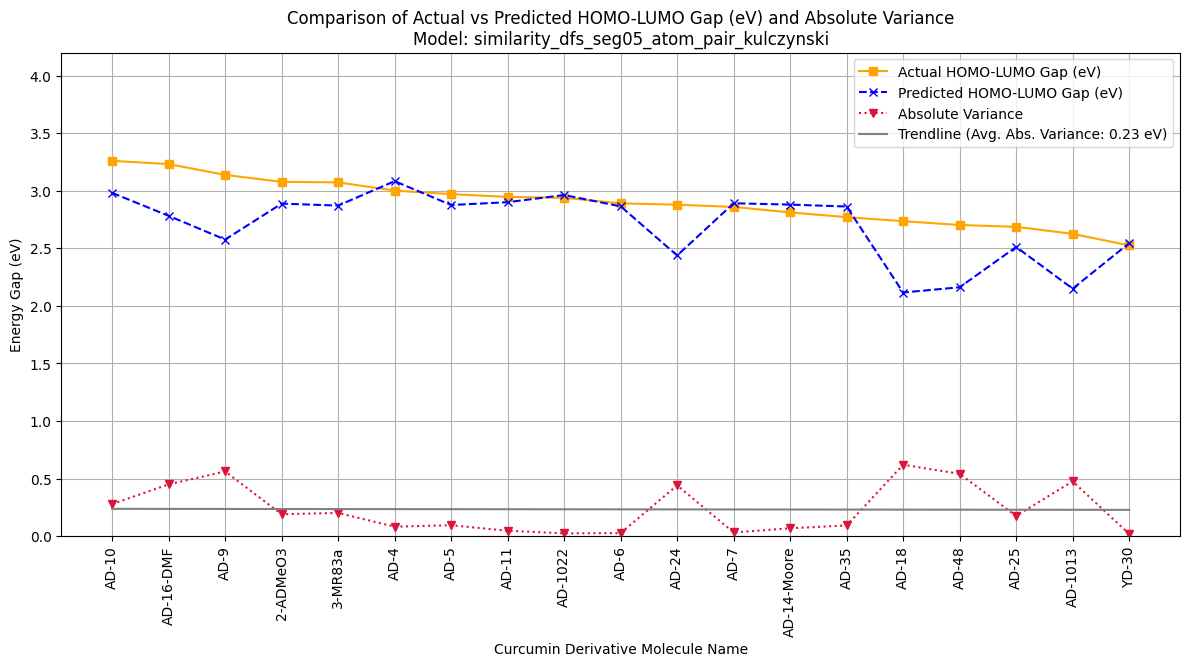

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 7637, number of used features: 1045
[LightGBM] [Info] Start training from score 2.701246


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



___________________________________________________________________
Model similarity_dfs_seg06_atom_pair_cosine
MAE Value: 0.08702 & RMSE Value: 0.16820
Prediction --> model MAE: 0.18954 & RMSE: 0.05706
Prediction --> model R2 Score: -0.4856
___________________________________________________________________


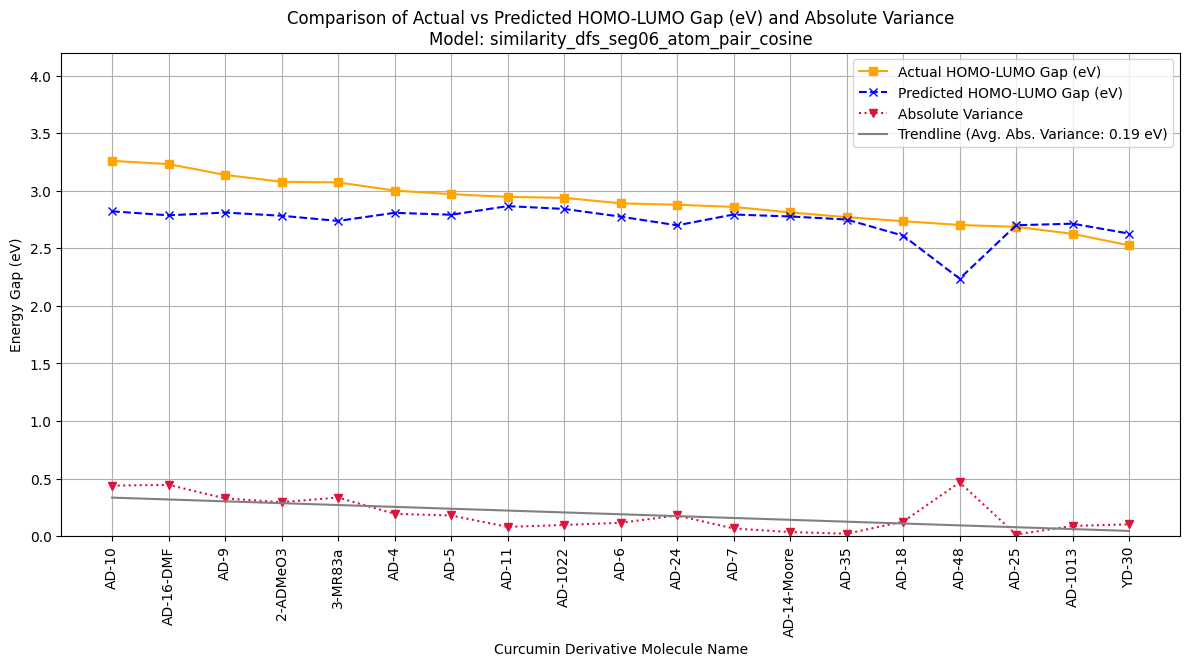

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# List of the best model dataframes
best_models_all_segments = ["similarity_dfs_seg01_atom_pair_cosine",
                            "similarity_dfs_seg02_atom_pair_cosine", 
                            "similarity_dfs_seg03_atom_pair_kulczynski", 
                            "similarity_dfs_seg04_atom_pair_kulczynski", 
                            "similarity_dfs_seg05_atom_pair_kulczynski",
                            "similarity_dfs_seg06_atom_pair_cosine"]

# Iterate through the list of best models
for model_name in best_models_all_segments:
    # Dynamically reference the corresponding dataframe
    model_df = globals()[model_name]
    
    x = model_df.iloc[:, 4:]
    y = model_df['GAP_calc']
    
    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=123)
    
    # Initialize and train the LightGBM model
    tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
    model = lgb.LGBMRegressor(**tuned_params)
    model.fit(x_train, y_train)
    
    # Make predictions and calculate R² score
    y_pred = model.predict(x_test)
    
    # Calculate MAE Value and RMSE for the model
    mae_model = mean_absolute_error(y_test, y_pred)
    rmse_model = mean_squared_error(y_test, y_pred, squared=False)
    
    # Calculate R² score for the model
    r2_model = model.score(x_test, y_test)

    # Ensure curcumin_df_mf's features are passed as a DataFrame for prediction
    curcumin_df_mf_pred = curcumin_df_mf.copy()
    curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_df_mf.iloc[:, 5:].values)
    
    # Calculate MAE, RMSE, and R² for the predictions on curcumin_df_mf
    mae_predict = mean_absolute_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
    rmse_predict = mean_squared_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
    
    # For R², ensure both arrays are passed to the model's `score` function
    r2_predict = model.score(curcumin_df_mf.iloc[:, 5:], curcumin_df_mf['Homo-Lumo Gap (eV)'])
    
    print("___________________________________________________________________")
    print(f"Model {model_name}")
    print(f"MAE Value: {mae_model:.5f} & RMSE Value: {rmse_model:.5f}")
    print(f"Prediction --> model MAE: {mae_predict:.5f} & RMSE: {rmse_predict:.5f}")
    print(f"Prediction --> model R2 Score: {r2_predict:.4f}")   
    print("___________________________________________________________________")
    
    # Sort curcumin_df_mf_pred by 'Homo-Lumo Gap (eV)' in descending order and reset the index
    curcumin_df_mf_pred = curcumin_df_mf_pred.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)
    
    # Calculate the absolute variance between 'Homo-Lumo Gap (eV)' and 'Homo-Lumo Gap (eV) Pred'
    curcumin_df_mf_pred['absolute_variance'] = (curcumin_df_mf_pred['Homo-Lumo Gap (eV)'] - curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred']).abs()
    
    # Save DF
    curcumin_df_mf_pred.to_csv(path_or_buf=(f"C:/Users/Chamod Peiris/Documents/Curcumin_Scripts/curcumin_pred_48_{model_name}.csv"))

    # Calculate linear trendline for absolute variance
    x_vals = curcumin_df_mf_pred.index
    y_vals = curcumin_df_mf_pred['absolute_variance']
    coefficients = np.polyfit(x_vals, y_vals, 1)  # Fit a linear polynomial
    trendline = np.polyval(coefficients, x_vals)
    
    # Calculate the average absolute variance
    average_variance = y_vals.mean()
    
    # Plotting the actual vs predicted energy gaps
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot the actual values
    ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], marker='s', label='Actual HOMO-LUMO Gap (eV)', color='orange')
    
    # Plot the predicted values
    ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'], marker='x', linestyle='--', label='Predicted HOMO-LUMO Gap (eV)', color='blue')
    
    # Plot the absolute variance as a dotted line
    ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['absolute_variance'], marker='v', linestyle=':', label='Absolute Variance', color='crimson')
    
    # Plot the trendline for absolute variance
    ax1.plot(curcumin_df_mf_pred['Molecule'], trendline, linestyle='-', color='grey', label=f'Trendline (Avg. Abs. Variance: {average_variance:.2f} eV)')
    
    # Set labels for the axes and the range
    ax1.set_xlabel('Curcumin Derivative Molecule Name')
    ax1.set_ylabel('Energy Gap (eV)')
    ax1.set_ylim([0, 4.2])  # Adjust the y-axis range as needed
    ax1.tick_params(axis='y')
    ax1.legend(loc='upper right')
    
    # Customize the plot
    plt.title(f'Comparison of Actual vs Predicted HOMO-LUMO Gap (eV) and Absolute Variance\nModel: {model_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=90)
    
    # Show the plot
    plt.show()

In [23]:
intersect_df_seg01_atom_pair_cosine = similarity_dfs_seg01_atom_pair_cosine.iloc[:, :3]
intersect_df_seg02_atom_pair_cosine = similarity_dfs_seg02_atom_pair_cosine.iloc[:, :3]
intersect_df_seg03_atom_pair_kulczynski = similarity_dfs_seg03_atom_pair_kulczynski.iloc[:, :3]
intersect_df_seg04_atom_pair_kulczynski = similarity_dfs_seg04_atom_pair_kulczynski.iloc[:, :3]
intersect_df_seg05_atom_pair_kulczynski = similarity_dfs_seg05_atom_pair_kulczynski.iloc[:, :3]
intersect_df_seg06_atom_pair_cosine = similarity_dfs_seg06_atom_pair_cosine.iloc[:, :3]

intersect_df_seg01_atom_pair_cosine.columns

Index(['smiles', 'mol', 'GAP_calc'], dtype='object')

In [24]:
import pandas as pd

# List of dataframes
dataframes = [
    intersect_df_seg01_atom_pair_cosine,
    intersect_df_seg02_atom_pair_cosine,
    intersect_df_seg03_atom_pair_kulczynski,
    intersect_df_seg04_atom_pair_kulczynski,
    intersect_df_seg05_atom_pair_kulczynski,
    intersect_df_seg06_atom_pair_cosine
]

# Extract SMILES columns from all dataframes
smiles_sets = [set(df['smiles']) for df in dataframes]

# Find common SMILES across all dataframes
common_smiles = set.intersection(*smiles_sets)

# print number of comon smiles
print(f"Number of common SMILES: {len(common_smiles)}")

# Filter rows in each dataframe to only include those with common SMILES
filtered_dfs = [df[df['smiles'].isin(common_smiles)] for df in dataframes]
intersected_df = filtered_dfs[0]
intersected_df

Number of common SMILES: 8938


,smiles,mol,GAP_calc
0,O=C(O)c1noc(-c2c3c(c(-c4onc(C(=O)O)c4C(=O)O)c4...,<rdkit.Chem.rdchem.Mol object at 0x00000270D68...,1.741529
1,N#CC(C#N)=C1C=C(C(=O)O)OC(c2c3c(c(C4=CC(=C(C#N...,<rdkit.Chem.rdchem.Mol object at 0x00000270D68...,1.530241
2,N#Cc1noc(-c2c3c(c(-c4onc(C#N)c4C(=O)O)c4cscc24...,<rdkit.Chem.rdchem.Mol object at 0x00000270D68...,1.808127
3,Cn1c(C2=CC(=C(C#N)C#N)C=C(c3cc4c(=O)n(C)c(=O)c...,<rdkit.Chem.rdchem.Mol object at 0x00000270D81...,1.768740
4,O=C(O)c1onc(-c2c3c(c(-c4noc(C(=O)O)c4C(=O)O)c4...,<rdkit.Chem.rdchem.Mol object at 0x00000270D81...,1.770480
...,...,...,...
10201,CN1C(=O)C(=Cc2nc3ccc(-c4cocc4C(=O)c4ccc(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x00000270D86...,3.154428
10202,CN1C(=O)C(=Cc2ncc(-c3ccnc(-c4c5ccsc5nc5sc(F)c(...,<rdkit.Chem.rdchem.Mol object at 0x00000270FF8...,2.705406
10203,CN1C(=O)C(=Cc2nccc(C=CC(=O)C=Cc3ccnc(C=C4SC(=S...,<rdkit.Chem.rdchem.Mol object at 0x00000270D68...,2.804085
10204,CN1C(=O)C(=Cc2onc(-c3ncnc([SiH]4C=C5OCCOC5=C4)...,<rdkit.Chem.rdchem.Mol object at 0x00000270D67...,2.685491


In [25]:
intersected_df['Morgan Fingerprints'] = intersected_df['smiles'].apply(generate_morgan_fingerprint_safe)
intersected_df = intersected_df[intersected_df['Morgan Fingerprints'].notnull()].reset_index(drop=True)

morgan_com_df = pd.DataFrame(intersected_df['Morgan Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])
intersected_df = pd.concat([intersected_df, morgan_com_df], axis=1)
intersected_df = intersected_df.drop(columns=['Morgan Fingerprints'])

intersected_df

C:\Users\Chamod Peiris\AppData\Local\Temp\ipykernel_25264\4080543613.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,smiles,mol,GAP_calc,morgan_0,morgan_1,morgan_2,morgan_3,morgan_4,morgan_5,morgan_6,...,morgan_2038,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047
0,O=C(O)c1noc(-c2c3c(c(-c4onc(C(=O)O)c4C(=O)O)c4...,<rdkit.Chem.rdchem.Mol object at 0x00000270D68...,1.741529,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,N#CC(C#N)=C1C=C(C(=O)O)OC(c2c3c(c(C4=CC(=C(C#N...,<rdkit.Chem.rdchem.Mol object at 0x00000270D68...,1.530241,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,N#Cc1noc(-c2c3c(c(-c4onc(C#N)c4C(=O)O)c4cscc24...,<rdkit.Chem.rdchem.Mol object at 0x00000270D68...,1.808127,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Cn1c(C2=CC(=C(C#N)C#N)C=C(c3cc4c(=O)n(C)c(=O)c...,<rdkit.Chem.rdchem.Mol object at 0x00000270D81...,1.768740,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,O=C(O)c1onc(-c2c3c(c(-c4noc(C(=O)O)c4C(=O)O)c4...,<rdkit.Chem.rdchem.Mol object at 0x00000270D81...,1.770480,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8933,CN1C(=O)C(=Cc2nc3ccc(-c4cocc4C(=O)c4ccc(C(F)(F...,<rdkit.Chem.rdchem.Mol object at 0x00000270D86...,3.154428,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8934,CN1C(=O)C(=Cc2ncc(-c3ccnc(-c4c5ccsc5nc5sc(F)c(...,<rdkit.Chem.rdchem.Mol object at 0x00000270FF8...,2.705406,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8935,CN1C(=O)C(=Cc2nccc(C=CC(=O)C=Cc3ccnc(C=C4SC(=S...,<rdkit.Chem.rdchem.Mol object at 0x00000270D68...,2.804085,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8936,CN1C(=O)C(=Cc2onc(-c3ncnc([SiH]4C=C5OCCOC5=C4)...,<rdkit.Chem.rdchem.Mol object at 0x00000270D67...,2.685491,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
curcumin_df_mf

,Molecule,Molecular Weight,LogP,Homo-Lumo Gap (eV),Smiles,morgan_0,morgan_1,morgan_2,morgan_3,morgan_4,...,morgan_2038,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047
0,2-ADMeO3,532.345,5.02930,3.077,COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3-MR83a,472.293,5.01210,3.072,COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AD-10,472.293,5.01210,3.259,COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+]...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AD-1013,482.335,7.29270,2.625,COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1cc...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AD-1022,472.293,5.01210,2.938,COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)...,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,AD-11,444.239,4.40610,2.946,COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+]...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,AD-14-Moore,438.327,5.10970,2.811,CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,AD-16-DMF,377.199,4.84938,3.231,N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,AD-18,506.357,7.88370,2.735,COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,AD-24,512.361,7.30130,2.878,COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1988
[LightGBM] [Info] Number of data points in the train set: 6703, number of used features: 994
[LightGBM] [Info] Start training from score 2.688375


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



___________________________________________________________________________
MAE Value: 0.07955 & RMSE Value: 0.11853
Prediction --> model MAE: 0.35582 & RMSE: 0.16183
Prediction --> model R2 Score: -3.2134
***************************************************************************


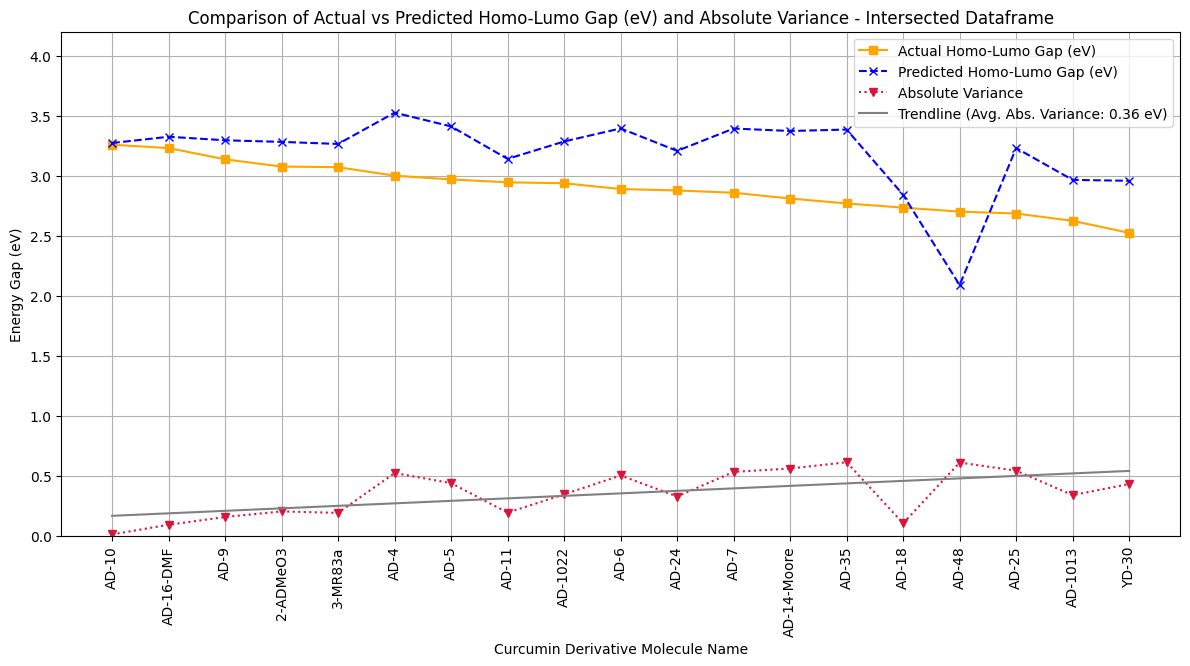

In [27]:
X = intersected_df.iloc[:, 3:]
y = intersected_df['GAP_calc']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Initialize and train the LightGBM model
tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
model = lgb.LGBMRegressor(**tuned_params)
model.fit(X_train, y_train)

# Make predictions and calculate R^2 score
y_pred = model.predict(X_test)

# Calculate MAE Value and RMSE for the model
mae_model = mean_absolute_error(y_test, y_pred)
rmse_model = mean_squared_error(y_test, y_pred, squared=False)

curcumin_df_mf_pred = curcumin_df_mf.copy()
curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_df_mf.iloc[:, 5:])

mae_predict = mean_absolute_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
rmse_predict = mean_squared_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])

# For R², ensure both arrays are passed to the model's `score` function
r2_predict = model.score(curcumin_df_mf.iloc[:, 5:], curcumin_df_mf['Homo-Lumo Gap (eV)'])

print("___________________________________________________________________________")
print(f"MAE Value: {mae_model:.5f} & RMSE Value: {rmse_model:.5f}")
print(f"Prediction --> model MAE: {mae_predict:.5f} & RMSE: {rmse_predict:.5f}")
print(f"Prediction --> model R2 Score: {r2_predict:.4f}")   
print("***************************************************************************")

# Sort curcumin_df_mf_pred by 'Homo-Lumo Gap (eV)' in descending order and reset the index
curcumin_df_mf_pred = curcumin_df_mf_pred.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)

# Calculate the absolute variance between 'Homo-Lumo Gap (eV)' and 'Homo-Lumo Gap (eV) Pred'
curcumin_df_mf_pred['absolute_variance'] = (curcumin_df_mf_pred['Homo-Lumo Gap (eV)'] - curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred']).abs()

# Save DF
curcumin_df_mf_pred.to_csv(path_or_buf=(f"C:/Users/Chamod Peiris/Documents/Curcumin_Scripts/curcumin_pred_Intersected.csv"))

# Calculate linear trendline for absolute variance
x_vals = curcumin_df_mf_pred.index
y_vals = curcumin_df_mf_pred['absolute_variance']
coefficients = np.polyfit(x_vals, y_vals, 1)  # Fit a linear polynomial
trendline = np.polyval(coefficients, x_vals)

# Calculate the average absolute variance
average_variance = y_vals.mean()

# Plotting the actual vs predicted energy gaps
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the actual values
ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], marker='s', label='Actual Homo-Lumo Gap (eV)', color='orange')

# Plot the predicted values
ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'], marker='x', linestyle='--', label='Predicted Homo-Lumo Gap (eV)', color='blue')

# Plot the absolute variance as a dotted line
ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['absolute_variance'], marker='v', linestyle=':', label='Absolute Variance', color='crimson')

# Plot the trendline for absolute variance
ax1.plot(curcumin_df_mf_pred['Molecule'], trendline, linestyle='-', color='grey', label=f'Trendline (Avg. Abs. Variance: {average_variance:.2f} eV)')

# Set labels for the axes and the range
ax1.set_xlabel('Curcumin Derivative Molecule Name')
ax1.set_ylabel('Energy Gap (eV)')
ax1.set_ylim([0, 4.2])  # Adjust the y-axis range as needed
ax1.tick_params(axis='y')
ax1.legend(loc='upper right')

# Customize the plot
plt.title('Comparison of Actual vs Predicted Homo-Lumo Gap (eV) and Absolute Variance - Intersected Dataframe')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [28]:
similarity_dfs_seg04_atom_pair_kulczynski.head()

,smiles,mol,GAP_calc,similarity_seg04_atom_pair_kulczynski,morgan_0,morgan_1,morgan_2,morgan_3,morgan_4,morgan_5,...,morgan_2038,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047
0,CN1C(=O)C2=C(C3=C(C#N)C(=C(C#N)C#N)SC3=O)N(C)C...,<rdkit.Chem.rdchem.Mol object at 0x00000270D82...,1.469415,0.420021,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,N#CC(C#N)=C1SC(=O)C(c2cnc(C3=C(C#N)C(=C(C#N)C#...,<rdkit.Chem.rdchem.Mol object at 0x00000270D82...,2.621637,0.352941,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,O=C(O)c1noc(-c2c3c(c(-c4onc(C(=O)O)c4C(=O)O)c4...,<rdkit.Chem.rdchem.Mol object at 0x00000270D68...,1.741529,0.551765,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,N#CC(C#N)=C1C=C(C(=O)O)OC(c2c3c(c(C4=CC(=C(C#N...,<rdkit.Chem.rdchem.Mol object at 0x00000270D68...,1.530241,0.451302,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,N#Cc1noc(-c2c3c(c(-c4onc(C#N)c4C(=O)O)c4cscc24...,<rdkit.Chem.rdchem.Mol object at 0x00000270D68...,1.808127,0.462032,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Explained Variance Ratio: [0.07538239 0.05188731 0.04218708 0.03922542 0.03435523 0.03330812
 0.02849752 0.02484362 0.02337346 0.02119793 0.01988941 0.01883144
 0.01773388 0.01600371 0.0147635  0.01432392 0.01374448 0.01299112
 0.01249782 0.01208605 0.0110117  0.01094463 0.01046787 0.00970985
 0.00918228 0.00863796 0.0083625  0.00823951 0.00808022 0.00771911
 0.00727565 0.00705388 0.00678223 0.00673786 0.00641723 0.00635968
 0.00607666 0.00591057 0.00567701 0.00557845 0.00537256 0.00528336
 0.00517492 0.00489825 0.00484058 0.00452066 0.00450321 0.00434359
 0.00419069 0.00412125 0.00402042 0.00388093 0.00385229 0.00376097
 0.00363393 0.00351985 0.00340628 0.00329975 0.00325092 0.00321712
 0.00300855 0.00299079 0.00280256 0.00278381 0.00271777 0.00262102
 0.00254508 0.00252347 0.00249061 0.00240443 0.00233749 0.00229009
 0.00225206 0.00219517 0.00214223 0.00208339 0.00200052 0.00195794
 0.00190805 0.00187244 0.00186299 0.00181301 0.00175624 0.0017064
 0.00168986 0.00167189 0.00164451 0.0

c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



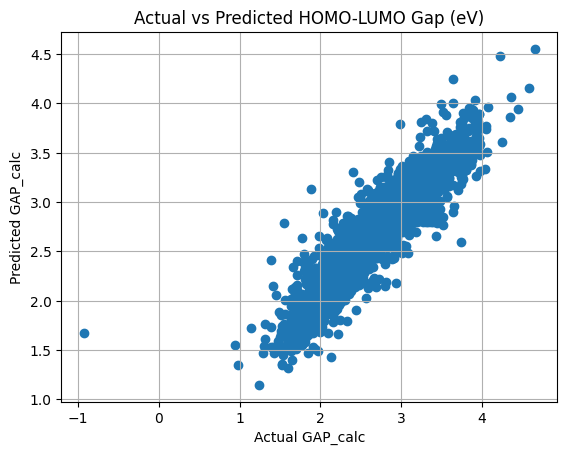

In [32]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt

# Extract features and target
X = similarity_dfs_seg04_atom_pair_kulczynski.iloc[:, 4:]
y = similarity_dfs_seg04_atom_pair_kulczynski['GAP_calc']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Perform PCA on the training and testing data (you can set the number of components as needed)
pca = PCA(n_components=0.90)  # This keeps 95% of the variance, you can choose the number of components directly too
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

# Check the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance_ratio}")
print(f"Number of components after PCA: {x_train_pca.shape[1]}")

# Initialize and train the LightGBM model
tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
model = lgb.LGBMRegressor(**tuned_params)
model.fit(x_train_pca, y_train)

# Make predictions on the test set
y_pred = model.predict(x_test_pca)

# Calculate evaluation metrics
mae_model = mean_absolute_error(y_test, y_pred)
rmse_model = mean_squared_error(y_test, y_pred, squared=False)
r2_model = model.score(x_test_pca, y_test)

# Print results
print(f"MAE: {mae_model:.5f}, RMSE: {rmse_model:.5f}, R2 Score: {r2_model:.4f}")

# You can also plot the predicted vs actual values as needed
plt.scatter(y_test, y_pred)
plt.xlabel('Actual GAP_calc')
plt.ylabel('Predicted GAP_calc')
plt.title('Actual vs Predicted HOMO-LUMO Gap (eV)')
plt.grid(True)
plt.show()

Explained Variance Ratio: [0.07538239 0.05188731 0.04218708 0.03922542 0.03435523 0.03330812
 0.02849752 0.02484362 0.02337346 0.02119793 0.01988941 0.01883144
 0.01773388 0.01600371 0.0147635  0.01432392 0.01374448 0.01299112
 0.01249782 0.01208605 0.0110117  0.01094463 0.01046787 0.00970985
 0.00918228 0.00863796 0.0083625  0.00823951 0.00808022 0.00771911
 0.00727565 0.00705388 0.00678223 0.00673786 0.00641723 0.00635968
 0.00607666 0.00591057 0.00567701 0.00557845 0.00537256 0.00528336
 0.00517492 0.00489825 0.00484058 0.00452066 0.00450321 0.00434359
 0.00419069 0.00412125 0.00402042 0.00388093 0.00385229 0.00376097
 0.00363393 0.00351985 0.00340628 0.00329975 0.00325092 0.00321712
 0.00300855 0.00299079 0.00280256 0.00278381 0.00271777 0.00262102
 0.00254508 0.00252347 0.00249061 0.00240443 0.00233749 0.00229009
 0.00225206 0.00219517 0.00214223 0.00208339 0.00200052 0.00195794
 0.00190805 0.00187244 0.00186299 0.00181301 0.00175624 0.0017064
 0.00168986 0.00167189 0.00164451 0.0

c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



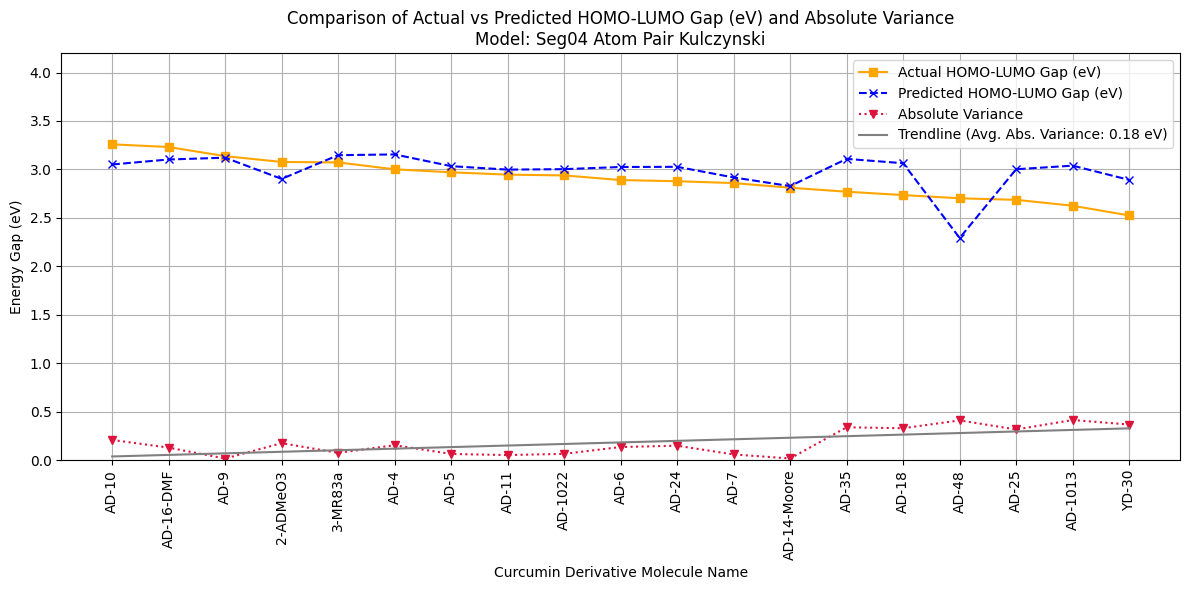

In [38]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

# Extract features and target from the chosen DataFrame
X = similarity_dfs_seg04_atom_pair_kulczynski.iloc[:, 4:]
y = similarity_dfs_seg04_atom_pair_kulczynski['GAP_calc']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Perform PCA on the training and testing data
pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

# Check the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance_ratio}")
print(f"Number of components after PCA: {x_train_pca.shape[1]}")

# Initialize and train the LightGBM model
tuned_params = {'n_estimators': 1000, 'learning_rate': 0.23685145356420312, 'num_leaves': 51}
model = lgb.LGBMRegressor(**tuned_params)
model.fit(x_train_pca, y_train)

# Make predictions on the test set
y_pred = model.predict(x_test_pca)

# Calculate evaluation metrics for the model
mae_model = mean_absolute_error(y_test, y_pred)
rmse_model = mean_squared_error(y_test, y_pred, squared=False)
r2_model = model.score(x_test_pca, y_test)

# Print model performance
print(f"MAE: {mae_model:.5f}, RMSE: {rmse_model:.5f}, R2 Score: {r2_model:.4f}")

# Assuming curcumin_df_mf already exists with the necessary features for prediction
curcumin_df_mf_pred = curcumin_df_mf.copy()

# Apply PCA transformation to curcumin_df_mf's feature set before prediction
curcumin_df_mf_pca = pca.transform(curcumin_df_mf.iloc[:, 5:])
curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'] = model.predict(curcumin_df_mf_pca)

# Calculate MAE, RMSE, and R² for the predictions on curcumin_df_mf
mae_predict = mean_absolute_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
rmse_predict = mean_squared_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'], squared=False)
r2_predict = model.score(curcumin_df_mf_pca, curcumin_df_mf['Homo-Lumo Gap (eV)'])

# Print prediction evaluation metrics
print("___________________________________________________________________")
print(f"Prediction MAE: {mae_predict:.5f}, RMSE: {rmse_predict:.5f}, R2 Score: {r2_predict:.4f}")
print("___________________________________________________________________")

# Sort curcumin_df_mf_pred by 'Homo-Lumo Gap (eV)' in descending order and reset index
curcumin_df_mf_pred = curcumin_df_mf_pred.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)

# Calculate the absolute variance between actual and predicted values
curcumin_df_mf_pred['absolute_variance'] = (curcumin_df_mf_pred['Homo-Lumo Gap (eV)'] - curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred']).abs()

# Save the prediction DataFrame
curcumin_df_mf_pred.to_csv("C:/Users/Chamod Peiris/Documents/Curcumin_Scripts/curcumin_pred_48_seg04_atom_pair_kulczynski.csv")

# Calculate linear trendline for absolute variance
x_vals = curcumin_df_mf_pred.index
y_vals = curcumin_df_mf_pred['absolute_variance']
coefficients = np.polyfit(x_vals, y_vals, 1)  # Fit a linear polynomial
trendline = np.polyval(coefficients, x_vals)

# Calculate the average absolute variance
average_variance = y_vals.mean()

# Plot actual vs predicted energy gaps
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot actual values
ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], marker='s', label='Actual HOMO-LUMO Gap (eV)', color='orange')

# Plot predicted values
ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'], marker='x', linestyle='--', label='Predicted HOMO-LUMO Gap (eV)', color='blue')

# Plot absolute variance
ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['absolute_variance'], marker='v', linestyle=':', label='Absolute Variance', color='crimson')

# Plot trendline for absolute variance
ax1.plot(curcumin_df_mf_pred['Molecule'], trendline, linestyle='-', color='grey', label=f'Trendline (Avg. Abs. Variance: {average_variance:.2f} eV)')

# Set axis labels and limits
ax1.set_xlabel('Curcumin Derivative Molecule Name')
ax1.set_ylabel('Energy Gap (eV)')
ax1.set_ylim([0, 4.2])  # Adjust y-axis range if needed
ax1.legend(loc='upper right')
ax1.tick_params(axis='x', rotation=90)

# Customize plot
plt.title('Comparison of Actual vs Predicted HOMO-LUMO Gap (eV) and Absolute Variance\nModel: Seg04 Atom Pair Kulczynski')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()